# RNA-SDB train / test split

This notebook investigates how to split Rfam families for RNA-SDB dataset.

In [2]:
import gzip
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [3]:
rfamseq_path = Path('./').resolve().parents[1] / 'datasets' / 'rfam' / 'rfamseq'

seq_dist = []
bases = set()

for filename in tqdm(rfamseq_path.glob('RF*.fa.gz')):
    rfam_family = filename.name.replace('.fa.gz', '')

    seq_count, noncanonical_count = 0, 0
    with gzip.open(filename, 'rt') as f:
        for line in f:
            assert line.startswith('>')
            line = next(f).strip().upper()

            assert re.match(r'^[A-Z]+$', line)
            seq_count += 1

            if re.search(r'[^ACGTU]', line):
                noncanonical_count += 1

            bases.update(line)

    seq_dist.append((rfam_family, seq_count, noncanonical_count))

df = pd.DataFrame(seq_dist, columns=['rfam_family', 'seq_count', 'noncanonical_count'])
df = df.sort_values('rfam_family').reset_index(drop=True)

4170it [00:19, 212.56it/s]


In [4]:
seq_count, noncanonical_count = df['seq_count'].sum(), df['noncanonical_count'].sum()
print(f'Total of sequences: {df["seq_count"].sum():,}')
print(f'Number of sequences with non-canonical bases: {noncanonical_count:,} ({noncanonical_count / seq_count:.1%})')
print(f'Number of sequences with canonical bases: {seq_count - noncanonical_count} ({(seq_count - noncanonical_count) / seq_count:.1%})')
print(f'Bases: {bases} ({len(bases)})')
print(f'Number of families: {len(df):,}')

Total of sequences: 3,117,783
Number of sequences with non-canonical bases: 13,382 (0.4%)
Number of sequences with canonical bases: 3104401 (99.6%)
Bases: {'S', 'T', 'R', 'K', 'V', 'W', 'H', 'Y', 'M', 'U', 'D', 'A', 'C', 'B', 'G', 'N'} (16)
Number of families: 4,170


In [6]:
df['canonical_count'] = df['seq_count'] - df['noncanonical_count']

Ultimately, we want to filter out sequences with non-canonical bases

In [28]:
# Perhaps want to have at least 20 sequences per family
df_filtered = df[df['canonical_count'] >= 20]
print(f'Number of families with at least 20 sequences: {len(df_filtered):,}')
num_seq = df_filtered["canonical_count"].sum()
print(f'Total of sequences in filtered families: {num_seq:,} ({num_seq / df["canonical_count"].sum():.1%})')

Number of families with at least 20 sequences: 2,262
Total of sequences in filtered families: 3,088,571 (99.5%)


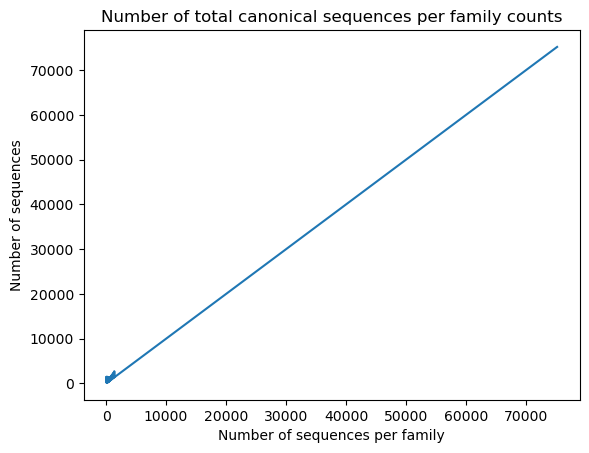

In [50]:
# Ignore the most dominant families for now
df_canonical_count = df_filtered[~df_filtered['rfam_family'].isin(['RF00005', 'RF00163', 'RF00001', 'RF00906'])].groupby('canonical_count')['canonical_count'].sum()
plt.plot(df_canonical_count.index, df_canonical_count.values)
plt.xlabel('Number of sequences per family')
plt.ylabel('Number of sequences')
plt.title('Number of total canonical sequences per family counts')
plt.show()

In [52]:
df_canonical_count.head(20)

canonical_count
20    760
21    483
22    660
23    552
24    624
25    400
26    780
27    594
28    840
29    667
30    750
31    589
32    704
33    627
34    782
35    805
36    756
37    740
38    912
39    897
Name: canonical_count, dtype: int64

Consider weighted sampling by inverse `canonical_count`

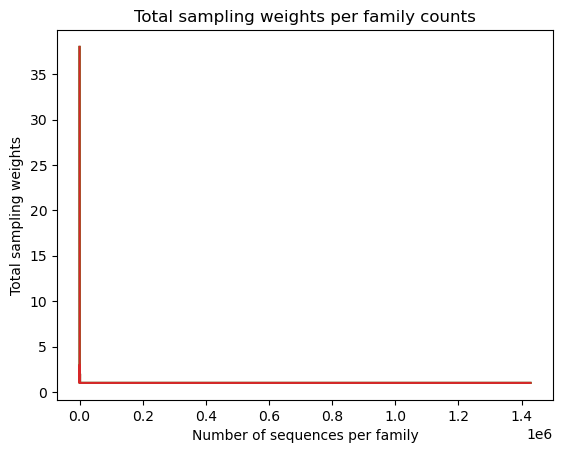

In [60]:
# Ignore the most dominant families for now
# df_canonical_count = df_filtered[~df_filtered['rfam_family'].isin(['RF00005', 'RF00163', 'RF00001', 'RF00906'])].groupby('canonical_count')['canonical_count'].sum()
df_canonical_count = df_filtered.groupby('canonical_count').count()
plt.plot(df_canonical_count.index, df_canonical_count.values)
plt.xlabel('Number of sequences per family')
plt.ylabel('Total sampling weights')
plt.title('Total sampling weights per family counts')
plt.show()

## Explore training / test split: 1
Test families: tRNA and tmRNA
- CL00001: RF00005 (tRNA), RF01852 (tRNA-Sec), RF00023 (tmRNA), RF02544 (mt-tmRNA), RF01851 (cyano_tmRNA), RF01850 (beta_tmRNA), RF01849 (alpha_tmRNA)
- RF00233 (Tymo_tRNA-like)
- RF01075 (TLS-PK1)
- RF01077 (TLS-PK2)
- RF01084 (TLS-PK3)
- RF01085 (TLS-PK4)
- RF01088 (TLS-PK5)
- RF01101 (TLS-PK6)

In [68]:
test_families = ['RF00005', 'RF01852', 'RF00023', 'RF02544', 'RF01851', 'RF01850', 'RF01849', 'RF00233', 'RF01075', 'RF01077', 'RF01084', 'RF01085', 'RF01088', 'RF01101']

In [69]:
df_test = df_filtered[df_filtered['rfam_family'].isin(test_families)]
df_train = df_filtered[~df_filtered['rfam_family'].isin(test_families)]

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 2,254
Number of test families: 8
Train ratio: 53.4%


## Explore training / test split: 2
Test families: SRP RNA
- CL00003: RF00169 (Bacteria_small_SRP), RF01854 (Bacteria_large_SRP), RF00017 (Metazoa_SRP), RF01855 (Plant_SRP), RF01857 (Archaea_SRP), RF01502 (Fungi_SRP), RF01856 (Protozoa_SRP), RF01570 (Dictyostelium_SRP), RF04183 (Bacteroidales_small_SRP)

In [72]:
test_families = ['RF00169', 'RF01854', 'RF00017', 'RF01855', 'RF01857', 'RF01502', 'RF01856', 'RF01570', 'RF04183']

df_test = df_filtered[df_filtered['rfam_family'].isin(test_families)]
df_train = df_filtered[~df_filtered['rfam_family'].isin(test_families)]

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 2,254
Number of test families: 8
Train ratio: 98.4%


In [75]:
# Sampled to get to 1/9
target = df_filtered["canonical_count"].sum() / 9

while df_test["canonical_count"].sum() < target:
    sample_family = df_train.sample(1)
    df_test = pd.concat([df_test, sample_family])
    df_train = df_train.drop(sample_family.index)

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 1,873
Number of test families: 390
Train ratio: 88.8%


## Explore training / test split: 3
Test families: telomerase RNA
- CL00004: RF01050 (Sacc_telomerase), RF00024 (Telomerase-vert), RF00025 (Telomerase-cil), RF02462 (Telomerase_Asco)

In [76]:
test_families = ['RF01050', 'RF00024', 'RF00025', 'RF02462']

df_test = df_filtered[df_filtered['rfam_family'].isin(test_families)]
df_train = df_filtered[~df_filtered['rfam_family'].isin(test_families)]

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

# Sampled to get to 1/9
target = df_filtered["canonical_count"].sum() / 9

while df_test["canonical_count"].sum() < target:
    sample_family = df_train.sample(1)
    df_test = pd.concat([df_test, sample_family])
    df_train = df_train.drop(sample_family.index)

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 2,259
Number of test families: 3
Train ratio: 100.0%
Number of train families: 1,425
Number of test families: 837
Train ratio: 88.9%


## Explore training / test split: 4
Test families: 5S rRNA
- CL00113: RF00001 (5S_rRNA), RF02547 (mtPerm-5S)
- RF02555 (hveRNA)
- RF02554 (ppoRNA)

In [77]:
test_families = ['RF00001', 'RF02547', 'RF02555', 'RF02554']

df_test = df_filtered[df_filtered['rfam_family'].isin(test_families)]
df_train = df_filtered[~df_filtered['rfam_family'].isin(test_families)]

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

# Sampled to get to 1/9
target = df_filtered["canonical_count"].sum() / 9

while df_test["canonical_count"].sum() < target:
    sample_family = df_train.sample(1)
    df_test = pd.concat([df_test, sample_family])
    df_train = df_train.drop(sample_family.index)

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 2,261
Number of test families: 1
Train ratio: 95.5%
Number of train families: 2,042
Number of test families: 220
Train ratio: 88.8%


## Explore training / test split: 5
Test families: RNase P
- CL00002: RF00010 (RNaseP_bact_a), RF00009 (RNaseP_nuc), RF00011 (RNaseP_bact_b), RF00373 (RNaseP_arch), RF02357 (RNaseP-T), RF00030 (RNase_MRP), RF01577 (RNase_P)

In [78]:
test_families = ['RF00010', 'RF00009', 'RF00011', 'RF00373', 'RF02357', 'RF00030', 'RF01577']

df_test = df_filtered[df_filtered['rfam_family'].isin(test_families)]
df_train = df_filtered[~df_filtered['rfam_family'].isin(test_families)]

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

# Sampled to get to 1/9
target = df_filtered["canonical_count"].sum() / 9

while df_test["canonical_count"].sum() < target:
    sample_family = df_train.sample(1)
    df_test = pd.concat([df_test, sample_family])
    df_train = df_train.drop(sample_family.index)

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 2,256
Number of test families: 6
Train ratio: 99.7%
Number of train families: 1,533
Number of test families: 729
Train ratio: 88.8%


## Explore training / test split: 6
Test families: Group 1 and 2 introns
- CL00102: RF01998 (group-II-D1D4-1), RF01999 (group-II-D1D4-2), RF02001 (group-II-D1D4-3), RF02003 (group-II-D1D4-4), RF02004 (group-II-D1D4-5), RF02005 (group-II-D1D4-6), RF02012 (group-II-D1D4-7)
- RF00029 (Intron_gpII)
- RF00028 (Intron_gpI)

In [79]:
test_families = ['RF01998', 'RF01999', 'RF02001', 'RF02003', 'RF02004', 'RF02005', 'RF02012', 'RF00029', 'RF00028']

df_test = df_filtered[df_filtered['rfam_family'].isin(test_families)]
df_train = df_filtered[~df_filtered['rfam_family'].isin(test_families)]

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

# Sampled to get to 1/9
target = df_filtered["canonical_count"].sum() / 9

while df_test["canonical_count"].sum() < target:
    sample_family = df_train.sample(1)
    df_test = pd.concat([df_test, sample_family])
    df_train = df_train.drop(sample_family.index)

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 2,253
Number of test families: 9
Train ratio: 99.1%
Number of train families: 1,961
Number of test families: 301
Train ratio: 88.9%


## Explore training / test split: 7
Test families: 23S rRNA
- CL00112: RF00002 (5_8S_rRNA), RF02540 (LSU_rRNA_archaea), RF02541 (LSU_rRNA_bacteria), RF02543 (LSU_rRNA_eukarya), RF02546 (LSU_trypano_mito)

In [80]:
test_families = ['RF00002', 'RF02540', 'RF02541', 'RF02543', 'RF02546']

df_test = df_filtered[df_filtered['rfam_family'].isin(test_families)]
df_train = df_filtered[~df_filtered['rfam_family'].isin(test_families)]

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

# Sampled to get to 1/9
target = df_filtered["canonical_count"].sum() / 9

while df_test["canonical_count"].sum() < target:
    sample_family = df_train.sample(1)
    df_test = pd.concat([df_test, sample_family])
    df_train = df_train.drop(sample_family.index)

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 2,258
Number of test families: 4
Train ratio: 98.0%
Number of train families: 1,959
Number of test families: 303
Train ratio: 84.3%


## Explore training / test split: 8
Test families: 13S rRNA
- RF01959 (SSU_rRNA_archaea), RF00177 (SSU_rRNA_bacteria), RF01960 (SSU_rRNA_eukarya), RF02542 (SSU_rRNA_microsporidia), RF02545 (SSU_trypano_mito)

In [81]:
test_families = ['RF01959', 'RF00177', 'RF01960', 'RF02542', 'RF02545']

df_test = df_filtered[df_filtered['rfam_family'].isin(test_families)]
df_train = df_filtered[~df_filtered['rfam_family'].isin(test_families)]

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

# Sampled to get to 1/9
target = df_filtered["canonical_count"].sum() / 9

while df_test["canonical_count"].sum() < target:
    sample_family = df_train.sample(1)
    df_test = pd.concat([df_test, sample_family])
    df_train = df_train.drop(sample_family.index)

print(f'Number of train families: {len(df_train):,}')
print(f'Number of test families: {len(df_test):,}')
print(f'Train ratio: {df_train["canonical_count"].sum() / df_filtered["canonical_count"].sum():.1%}')

Number of train families: 2,258
Number of test families: 4
Train ratio: 98.6%
Number of train families: 2,099
Number of test families: 163
Train ratio: 88.9%


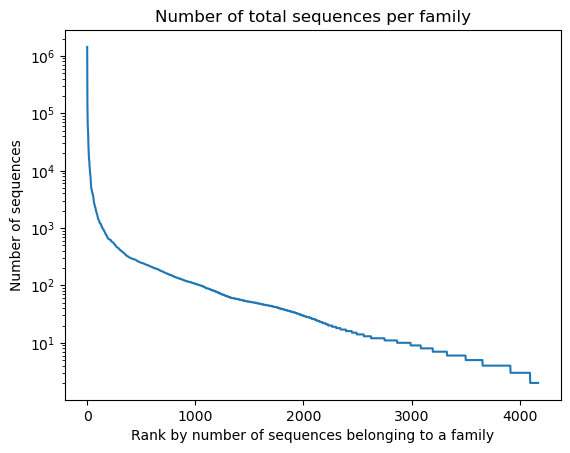

Number of families with more than 100 sequences: 1044
Number of families with more than 50 sequences: 1538

Top 20 families by number of sequences:
     rfam_family  seq_count
4        RF00005    1430083
156      RF00163     190679
0        RF00001     140644
860      RF00906     100466
2169     RF02271      75164
96       RF00097      60610
3958     RF04088      58340
418      RF00436      53279
25       RF00026      47589
16       RF00017      42477
2434     RF02543      33318
31       RF00032      30503
2432     RF02541      25446
170      RF00177      22178
1868     RF01960      21653
4095     RF04225      17681
3        RF00004      16770
28       RF00029      15729
98       RF00100      15277
3894     RF04021      14780

Bottom 20 families by number of sequences:
     rfam_family  seq_count
3911     RF04039          2
3912     RF04040          2
3858     RF03985          2
3860     RF03987          2
3872     RF03999          2
3875     RF04002          2
3876     RF04003        

In [72]:
seq_counts = sorted(df['seq_count'].values)[::-1]
sns.lineplot(x=np.arange(1, len(seq_counts) + 1), y=seq_counts)
plt.yscale('log')
plt.xlabel('Rank by number of sequences belonging to a family')
plt.ylabel('Number of sequences')
plt.title('Number of total sequences per family')
plt.show()

print(f'Number of families with more than 100 sequences: {(df['seq_count'] > 100).sum()}')
print(f'Number of families with more than 50 sequences: {(df['seq_count'] > 50).sum()}')
print()
print(f'Top 20 families by number of sequences:')
print(df.sort_values('seq_count', ascending=False).head(20)[['rfam_family', 'seq_count']].to_string())
print()
print(f'Bottom 20 families by number of sequences:')
print(df.sort_values('seq_count', ascending=False).tail(20)[['rfam_family', 'seq_count']].to_string())

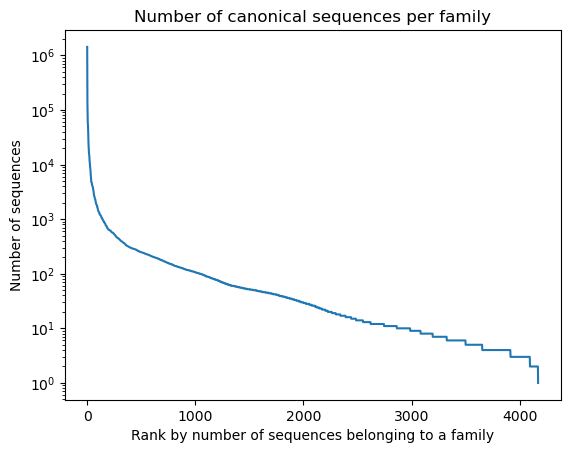

Number of families with more than 100 sequences: 1041
Number of families with more than 50 sequences: 1532

Top 20 families by number of sequences:
     rfam_family  canonical_count
4        RF00005          1428283
156      RF00163           190058
0        RF00001           139807
860      RF00906            98960
2169     RF02271            75163
96       RF00097            60539
3958     RF04088            57912
418      RF00436            53223
25       RF00026            47389
16       RF00017            41393
2434     RF02543            31874
31       RF00032            30458
2432     RF02541            24463
170      RF00177            21479
1868     RF01960            20786
4095     RF04225            17678
3        RF00004            16607
28       RF00029            15665
98       RF00100            15050
3894     RF04021            14673

Bottom 20 families by number of sequences:
     rfam_family  canonical_count
3880     RF04007                2
3881     RF04008          

In [73]:
df['canonical_count'] = df['seq_count'] - df['noncanonical_count']
seq_counts = sorted(df['canonical_count'].values)[::-1]
sns.lineplot(x=np.arange(1, len(seq_counts) + 1), y=seq_counts)
plt.yscale('log')
plt.xlabel('Rank by number of sequences belonging to a family')
plt.ylabel('Number of sequences')
plt.title('Number of canonical sequences per family')
plt.show()

print(f'Number of families with more than 100 sequences: {(df['canonical_count'] > 100).sum()}')
print(f'Number of families with more than 50 sequences: {(df['canonical_count'] > 50).sum()}')
print()
print(f'Top 20 families by number of sequences:')
print(df.sort_values('canonical_count', ascending=False).head(20)[['rfam_family', 'canonical_count']].to_string())
print()
print(f'Bottom 20 families by number of sequences:')
print(df.sort_values('canonical_count', ascending=False).tail(20)[['rfam_family', 'canonical_count']].to_string())

Distribution of total vs. canonical does not make much difference